# Accurate interpolation of non-periodic data on a uniform grid

In [117]:
# import libraries
import numpy as np
import scipy
from scipy.fft import fft, ifft
import matplotlib.pyplot as plt
from numpy.testing import assert_allclose as isclose
# set up test problem
L, N, Ni   = 2, 64, 128
dx, dxi    = L/N, L/Ni
f1         = lambda x : x
f2         = lambda x : np.exp(10*x)
f3         = lambda x : 1/(1+25*x**2)
# 1D arrays
x          = np.linspace(-1, 1, N  + 1)[:-1]
xi         = np.linspace(-1, 1, Ni + 1)[:-1]
y1, y2, y3 = f1(x), f2(x), f3(x)

def error_metric(y1, y2):
    return np.abs(y1 - y2)

def plot_result(x, y1, y2, y3, xi, y1i, y2i, y3i):
    fig, axs = plt.subplots(2, 3, figsize=(12,6), dpi=160, sharex=True)
    row1, row2 = axs
    ax1, ax2, ax3 = row1
    ax4, ax5, ax6 = row2
    ax1.scatter(x, y1, s = 9, label="f(x) = x")
    ax2.scatter(x, y2, s = 9, label="f(x) = exp(10*x)")
    ax3.scatter(x, y3, s = 9, label=r"$f(x) = \frac{1}{1 + 25 * x^2}$")
    ae1, ae2, ae3 = error_metric(y1i, f1(xi)), error_metric(y2i, f2(xi)), error_metric(y3i, f3(xi))
    ax1.plot(xi, y1i, c = "orange", label=f"Error = {np.mean(ae1):2.2e}")
    ax2.plot(xi, y2i, c = "orange", label=f"Error = {np.mean(ae2):2.2e}")
    ax3.plot(xi, y3i, c = "orange", label=f"Error = {np.mean(ae3):2.2e}")
    re1, re2, re3 = ae1/np.abs(y1i), ae2/np.abs(y2i), ae3/np.abs(y3i)
    ax4.set_ylim(1e-4, 1)
    ax5.set_ylim(1e-4, 1)
    ax6.set_ylim(1e-4, 1)
    ax4.set_yscale("log")
    ax5.set_yscale("log")
    ax6.set_yscale("log")
    ax4.plot(xi, re1, c = "orange", label=f"Rel. Error = {np.mean(re1):2.2e}")
    ax5.plot(xi, re2, c = "orange", label=f"Rel. Error = {np.mean(re2):2.2e}")
    ax6.plot(xi, re3, c = "orange", label=f"Rel. Error = {np.mean(re3):2.2e}")
    ax1.legend()
    ax2.legend()
    ax3.legend()
    ax4.legend()
    ax5.legend()
    ax6.legend()
    plt.show()


## Approach 1: Pretend the function is periodic



/home/xerox/.local/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/tmp/ipykernel_15067/1459354707.py:33: RuntimeWarning: invalid value encountered in divide
  re1, re2, re3 = ae1/np.abs(y1i), ae2/np.abs(y2i), ae3/np.abs(y3i)


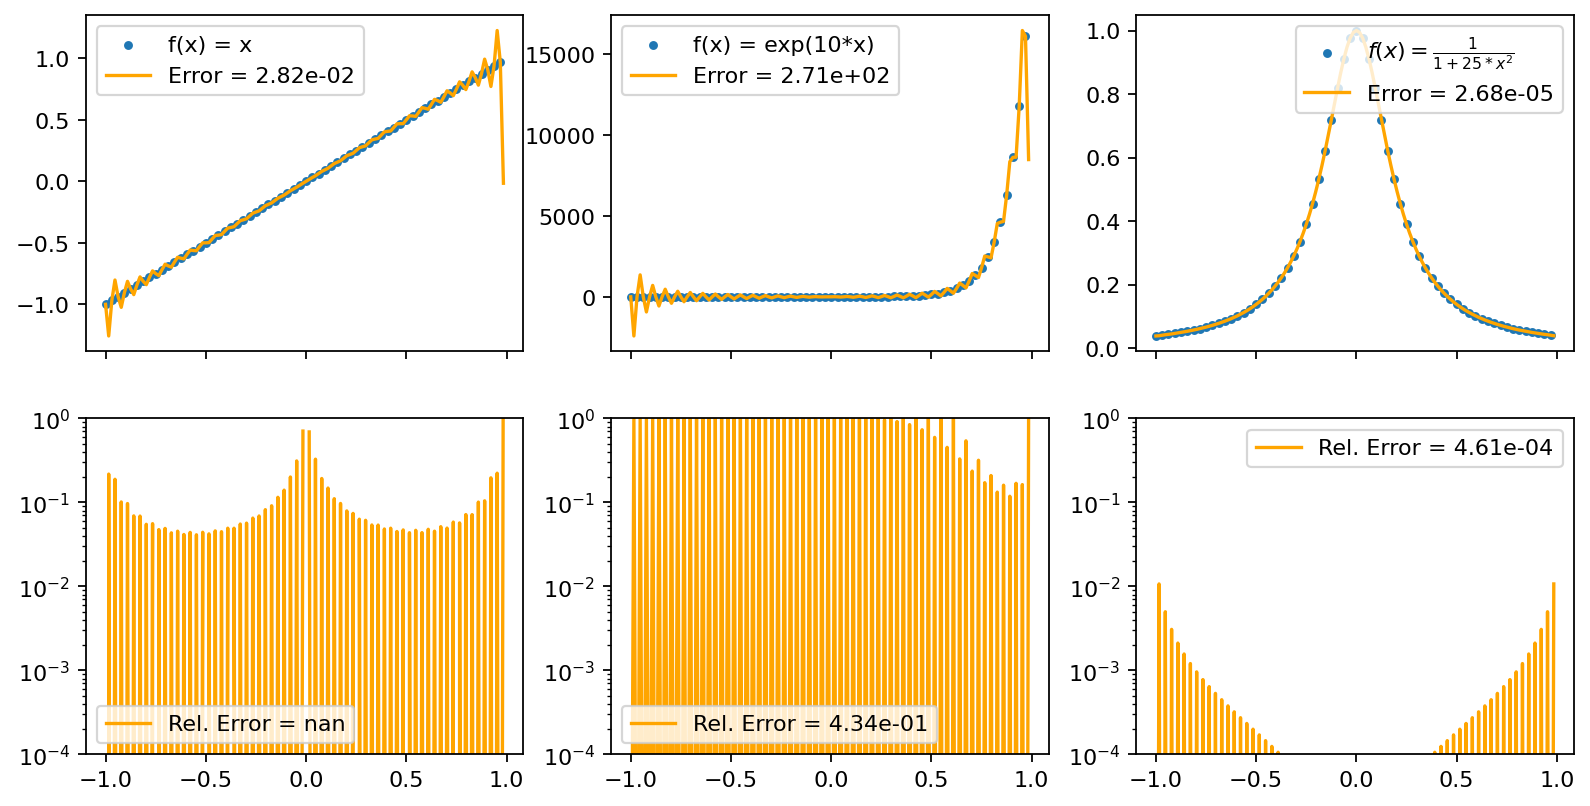

In [118]:
def int_1(y, N = N, Ni = Ni):
    yhat = fft(y, norm="forward")
    Npad = int(Ni/2 - N/2)
    yt   = np.fft.fftshift(yhat)
    ypad = np.concatenate([np.zeros(Npad), yt, np.zeros(Npad)])
    ypad = np.fft.fftshift(ypad)
    yi   = ifft(ypad, norm="forward")
    return yi

y1i, y2i, y3i = int_1(y1), int_1(y2), int_1(y3)
plot_result(x, y1, y2, y3, xi, y1i, y2i, y3i)

## Approach 2: Make data periodic by convolving it with a bell function

Asymptotic Fourier Coefficients for a C ∞ Bell (Smoothed-“Top-Hat”) & the Fourier Extension Problem

John P. Boyd 2005, DOI: 10.1007/s10915-005-9010-7

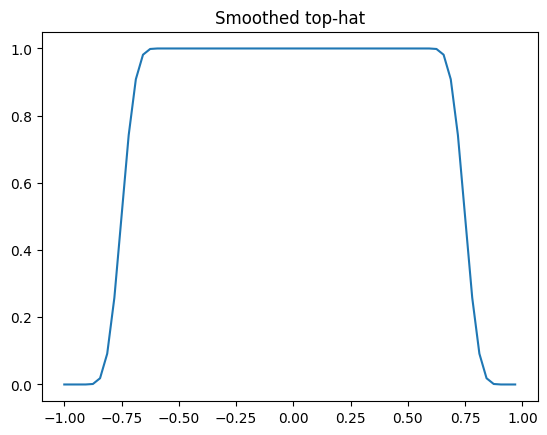

In [119]:
chi = 0.5
psi = 1
b = int(np.argwhere(xi>-chi)[0])
L = 0.911 * np.sqrt(1 - chi/psi) * np.sqrt(len(x)/2)

#Eq. 2
def erflike(x, L):
    if x <= -1:
        return -1
    elif x >= 1:
        return  1
    else:
        return scipy.special.erf(L * x / np.sqrt(1 - x**2))

#Eq. 3
def ramp(x, L):
    return 0.5 * (1 + erflike(x, L))

#Eq. 5
def bell(x, L, chi, psi):
#   Eq. 4
    Omega = (psi - chi) / 2
    if -psi <= x and x < -chi:
        return ramp(+(x + chi + Omega)/Omega, L)
    elif -chi <= x and x < chi:
        return 1
    else:
        return ramp(-(x - chi - Omega)/Omega, L)


bell_array = np.array([bell(r, L, chi, psi) for r in x]).astype(float)
plt.title("Smoothed top-hat")
plt.plot(x, bell_array)

### Non-overlapping extension

/tmp/ipykernel_15067/1459354707.py:33: RuntimeWarning: divide by zero encountered in divide
  re1, re2, re3 = ae1/np.abs(y1i), ae2/np.abs(y2i), ae3/np.abs(y3i)
/tmp/ipykernel_15067/1459354707.py:33: RuntimeWarning: invalid value encountered in divide
  re1, re2, re3 = ae1/np.abs(y1i), ae2/np.abs(y2i), ae3/np.abs(y3i)


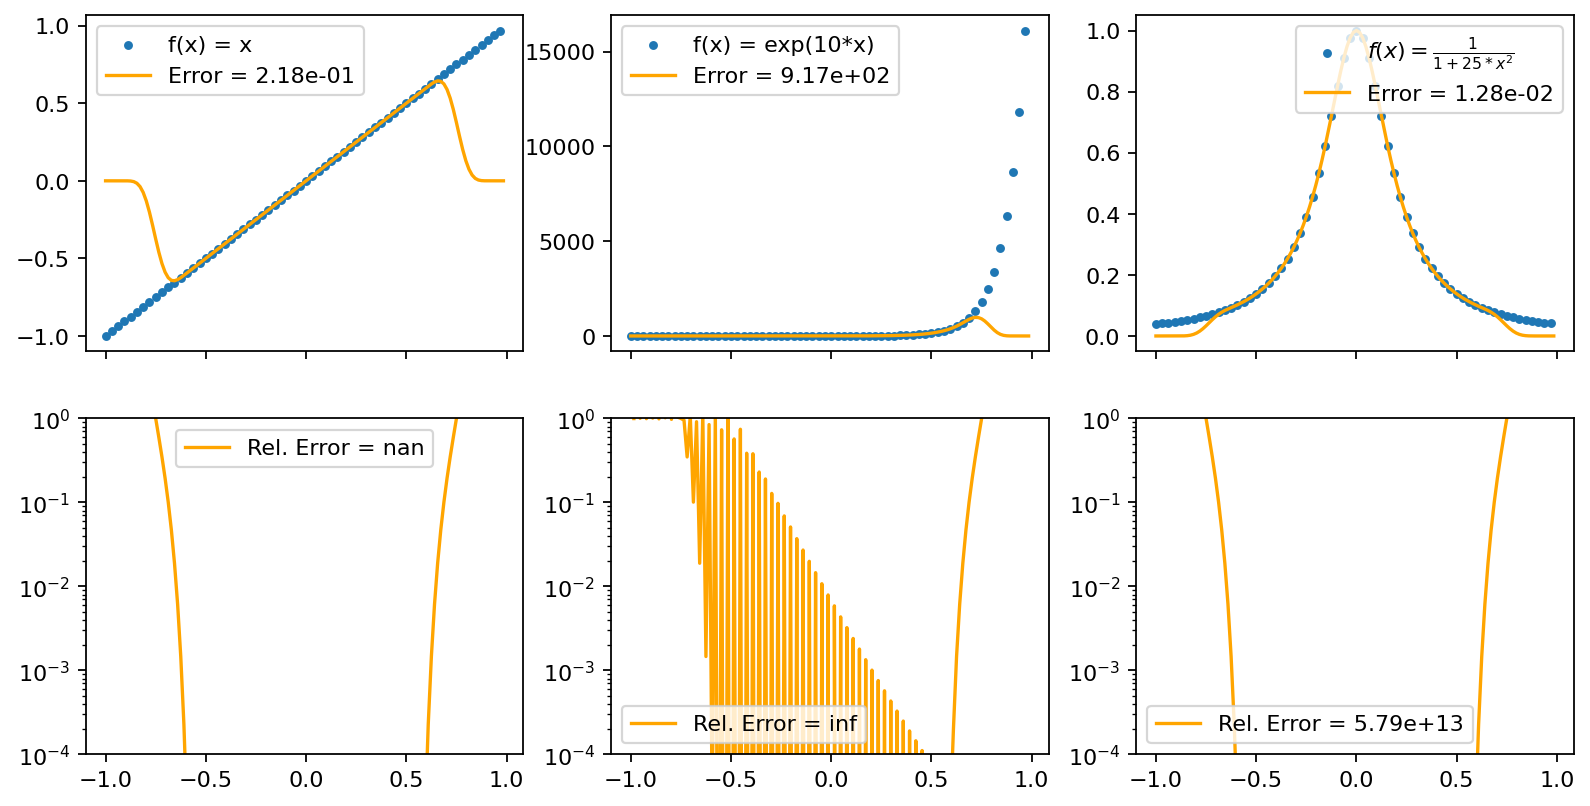

In [120]:
def int_2(y):
    return int_1(y * bell_array)


y1i, y2i, y3i = int_2(y1), int_2(y2), int_2(y3)
plot_result(x, y1, y2, y3, xi, y1i, y2i, y3i)

### Overlapped extension

In [121]:

def scale_x_to_psi(x, psi):
    a, b = x[0], x[-1]
    xs   = (x - a) / (b - a)
    xs   = xs * (2 * psi) - psi
    return xs

#####################################################################################################
#
# -2*psi+chi       -psi                -chi          0          chi              psi        2*psi-chi
# -------------------------------------xxxxxxxxxxxxxxxxxxxxxxxxxxxx-----------------------------------
#        ghost boundary                        physical domain                    ghost boundary
#
#
######################################################################################################

def getIntricateBell(x, f, ghost_boundary, L):

    # set length of physical domain to 1
    # 2 * psi = C * (len(f) - 2 * ghostBoundary)
    # half of the ghost boundary is extension domain
    # chi = C * 2 * ghostBoundary / 2
    chi          = (len(f) - 2 * ghost_boundary)/2
    psi          = (len(f) -     ghost_boundary)/2
    # rescale x so that it takes the value 2 * psi - chi at the boundaries
    xs           = scale_x_to_psi(x, 2 * psi - chi)
    twopsishift  = len(f) - ghost_boundary


    ys  = np.zeros(f.shape, dtype=complex)
    for i, x in enumerate(xs):
        Omega = (psi - chi) / 2
        if x < -chi:
            ys[i] = bell(xs[i], L, chi, 2 * psi - chi) * f[i] + bell(xs[i + twopsishift], L, chi, 2 * psi - chi) * f[i + twopsishift]
        elif -chi <= x and x <= chi:
            ys[i] = f[i]
        elif chi < x:
            ys[i] = bell(xs[i], L, chi, 2 * psi - chi) * f[i] + bell(xs[i - twopsishift], L, chi, 2 * psi - chi) * f[i - twopsishift]

    half_ghost    = int(ghost_boundary/2)
    xs = scale_x_to_psi(xs, 1)
    x  = xs[half_ghost:-half_ghost]
    y  = ys[half_ghost:-half_ghost]

    plt.title("The periodically extended function")
    plt.plot(xs, ys, label="More than one period")
    plt.plot(x, y, label="One period")
    plt.legend()
    plt.show()

    return x, y, chi, psi

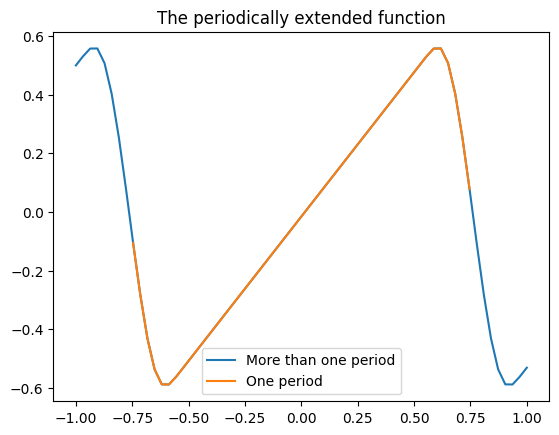

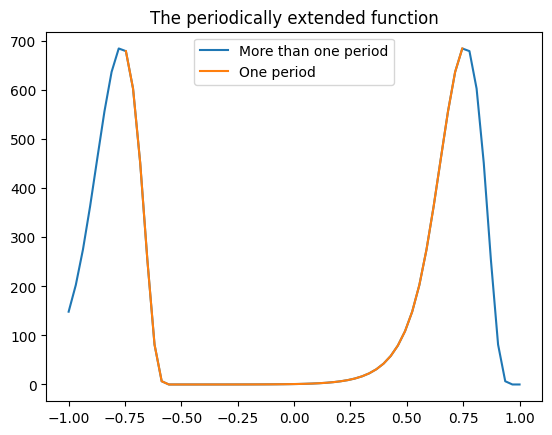

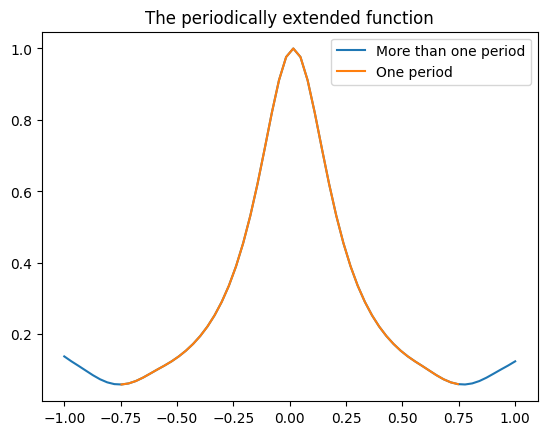

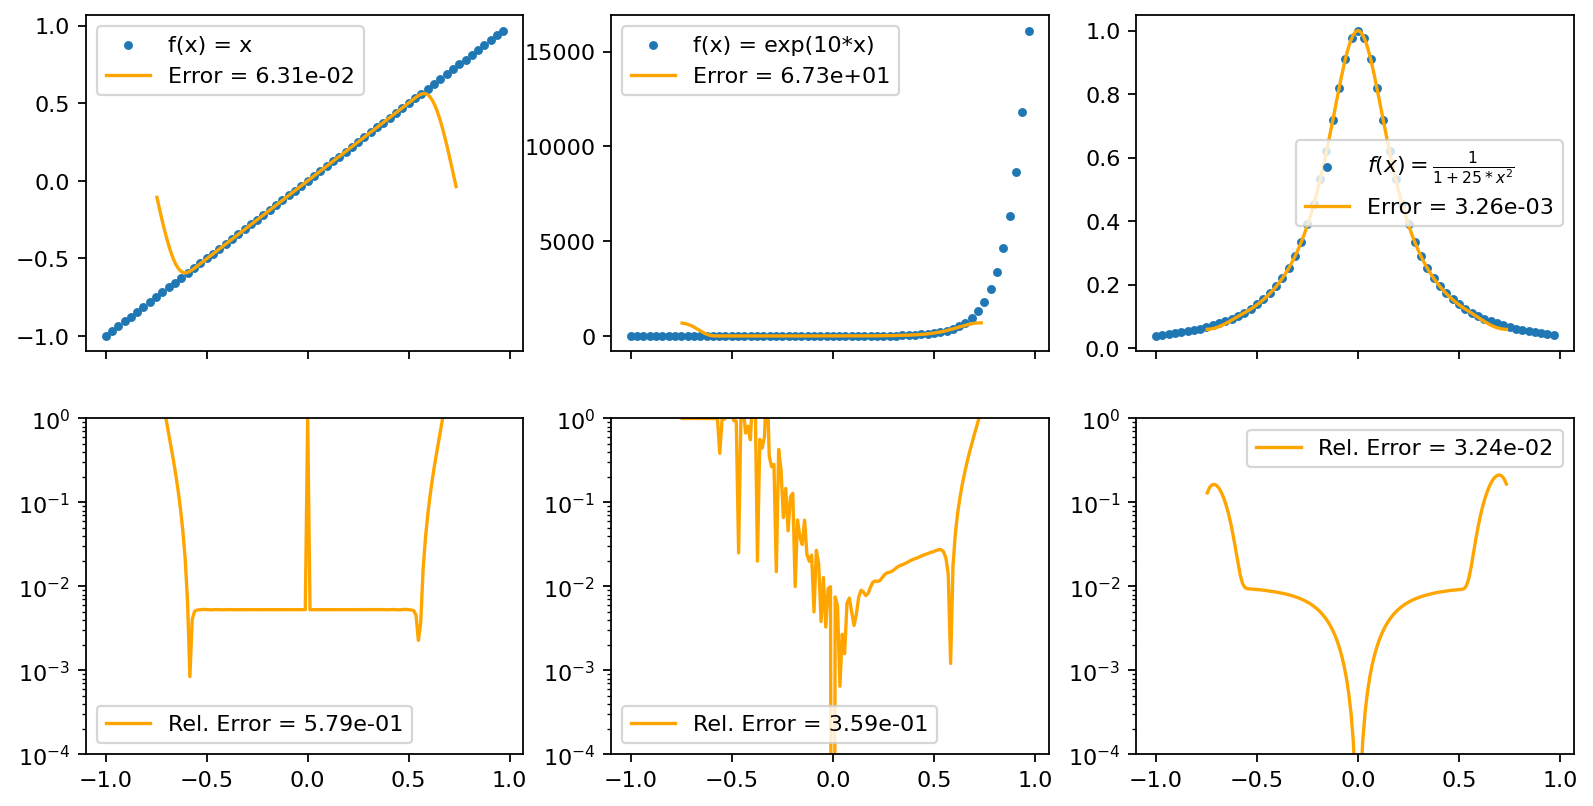

In [122]:
def int_3(y, N_ghost = 16):
    xs, yp, chi, psi = getIntricateBell(x, y, N_ghost, L = 2)
    return int_1(yp, N = len(yp))


y1i = int_3(y1)
y2i = int_3(y2)
y3i = int_3(y3)

xs  = np.linspace(-0.74603175, 0.74603175, Ni + 1)[:-1]

plot_result(x, y1, y2, y3, xs, y1i, y2i, y3i)

## Local Fourier Basis

Israeli, M., Vozovoi, L. & Averbuch, A. Spectral multidomain technique with Local Fourier Basis. J Sci Comput 8, 135–149 (1993). https://doi.org/10.1007/BF01060869

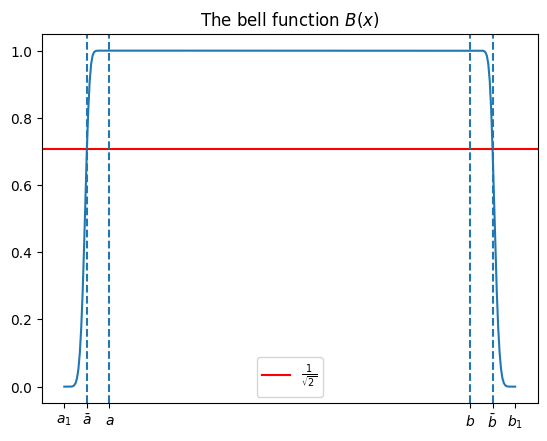

In [136]:
import numpy as np 
import matplotlib.pyplot as plt

L                 = 1
N                 = 256
dx                = L/(N - 1)
ghostBoundary     = 32
x                 = np.arange(-ghostBoundary, N + ghostBoundary) * dx

def theta(x, eps): 
    return np.pi/4 * ( 1 + np.sin( np.pi/2 * np.sin( np.pi/2 * np.sin ( np.pi/2 * x / eps ))))
    #return np.pi/4 * ( 1 + np.sin( np.pi/2 * x/eps ))
    #return x * 2 * np.pi
    
def sfunc(x, eps):
    return np.sin(theta(x, eps))

def cfunc(x, eps):
    return np.cos(theta(x, eps))

def bfunc(x, a1, a, b1, b):
    B = np.zeros(x.shape) 
    eps  = (b1 - b) / 2

    c = (x >= a1) * (x <= a)
    B[ c ] = sfunc( x[c] + eps, eps ) 
    c = (x >= a) *  (x <= b)
    B[ c ] = 1
    c = (x > b) * (x <= b1)
    B[ c ] = cfunc( x[c] - eps - b, eps)
    return B 

a1 =   - ghostBoundary * dx  
a  =     0
b  =     L 
b1 =   + ghostBoundary * dx  + L 
ab = (a + a1)/2
bb = (b + b1)/2
plt.title(r"The bell function $B(x)$") 
plt.plot(x, bfunc(x, a1, a, b1, b)) 
plt.axhline(1/np.sqrt(2), label=r"$\frac{1}{\sqrt{2}}$", c="r")
plt.axvline(a, ls="dashed")
plt.axvline(b, ls="dashed")
plt.axvline(ab, ls="dashed")
plt.axvline(bb, ls="dashed")
plt.xticks(ticks=[a1, ab, a, b, bb, b1], labels=[r"$a_1$", r"$\bar{a}$", r"$a$", r"$b$", r"$\bar{b}$", r"$b_1$", ])
plt.legend()
plt.show()



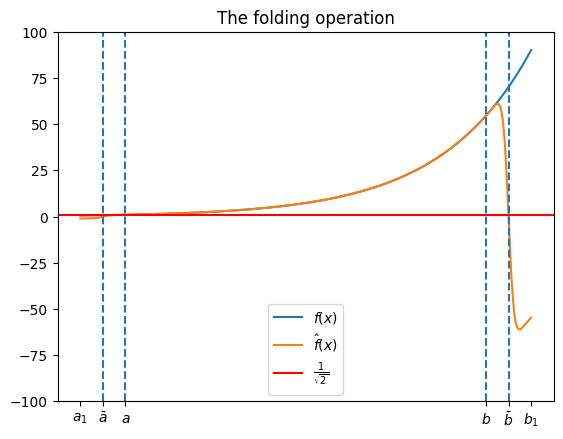

In [138]:

k = 4
def func(x):
    return np.exp(x * k)

def ddfunc(x):
    return k**2 * np.exp(x * k)
f      =   func(x)
ddfana = ddfunc(x)
B      = bfunc(x, a1, a, b1, b)
def folding(x, func, bfunc): 
    return bfunc(x, a1, a, b1, b) * func(x) - bfunc(2 * ab - x, a1, a, b1, b) * func(2 * ab - x) - bfunc(2 * bb - x, a1, a, b1, b) * func(2 * bb - x)

def fhat(f, B): 
    return f * B - np.flip(np.roll(B * f, -ghostBoundary)) - np.roll(B * f, ghostBoundary)


plt.title(r"The folding operation") 
plt.plot(x, func(x), label=r"$f(x)$") 
plt.plot(x, folding(x, func, bfunc), label=r"$\hat{f}(x)$") 
plt.axhline(1/np.sqrt(2), label=r"$\frac{1}{\sqrt{2}}$", c="r")
plt.axvline(a, ls="dashed")
plt.axvline(b, ls="dashed")
plt.axvline(ab, ls="dashed")
plt.axvline(bb, ls="dashed")
plt.ylim([-100, 100])
plt.xticks(ticks=[a1, ab, a, b, bb, b1], labels=[r"$a_1$", r"$\bar{a}$", r"$a$", r"$b$", r"$\bar{b}$", r"$b_1$", ])
plt.legend()
plt.show()


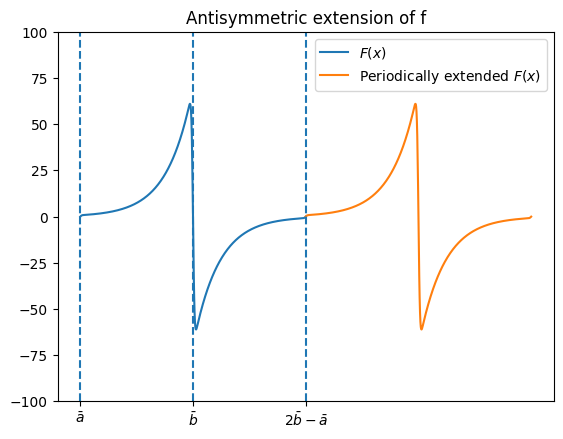

In [139]:

def Ffunc(x, func, bfunc):
    Nh  = N + ghostBoundary
    Nl  =  Nh * 2 - 1
    xl  = np.arange(-ghostBoundary/2, N + ghostBoundary/2) * dx
    # Exclude left boundary since it agrees with right boundary of xl
    xh = (xl + bb - ab)[1:]
    X  = np.arange(-ghostBoundary/2, Nl-ghostBoundary/2) * dx
    F  = np.zeros(Nl)
    F[:Nh] = folding(         xl, func, bfunc) 
    F[Nh:] = -folding(2 * bb - xh, func, bfunc)
    return X, F 

X, F = Ffunc(x, func, bfunc)

L = 2*bb - 2*ab
plt.title(r"Antisymmetric extension of f") 
plt.plot(X, F, label=r"$F(x)$") 
plt.plot(X + L, F, label=r"Periodically extended $F(x)$") 
plt.axvline(ab, ls="dashed")
plt.axvline(bb, ls="dashed")
plt.axvline(2 * bb - ab, ls="dashed")
plt.ylim([-100, 100])
plt.xticks(ticks=[ab, bb, 2 * bb - ab, ], labels=[r"$\bar{a}$", r"$\bar{b}$", r"$2 \bar{b} - \bar{a}$", ])
plt.legend()
plt.show()

### "Spectral Solution with a Subtraction Method to Improve Accuracy"
Matthew Green, Santa Clara University

In [123]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

def fDiffMat(order, dx):
    s = order
    mat = np.zeros((s, s))
    for k in range(1, s+1):
        for j in range(1, s+1):
            mat[j-1, k-1] = (j * dx)**k / np.math.factorial(k)

    return mat

def bDiffMat(order, dx):
    s = order
    mat = np.zeros((s, s))
    for k in range(1, s+1):
        for j in range(1, s+1):
            mat[j-1, k-1] = (-j * dx)**k / np.math.factorial(k)

    return mat

def fDiffVec(order, f):
    diff = np.zeros(order)
    for j in range(1, order + 1):
        diff[j-1] = f[j] - f[0]
    return diff

def bDiffVec(order, f):
    diff = np.zeros(order)
    for j in range(1, order + 1):
        diff[j-1] = (f[-1-j] - f[-1])
    return diff


def iterativeRefinement(A, b, tolerance = 1e-9):
    C = np.linalg.solve(A, b)
    residual      = b - A @ C
    residualError = np.sum(np.abs(residual))

    iteration = 0
    while residualError > tolerance:
        correction = np.linalg.solve(A, residual)
        C += correction
        residual = b - A @ C
        residualError = np.sum(np.abs(residual))
        iteration += 1
        if iteration > 100:
            break

    return C

def shiftx(x):
    return (x - x[0])/(x[-1] - x[0])

def cosineDiffVec(order, f, Dl, Dr):
    b = np.zeros(2*order)
    b[0] = f[ 0]
    b[1] = f[-1]
    for i in range(1, order):
        b[i*2    ] = Dl[i]/(np.pi)**(2*i)

    for i in range(1, order):
        b[i*2 + 1] = Dr[i]/(np.pi)**(2*i)

    return b

def cosineDiffMat(order):
    A = np.zeros((order*2, order*2))
    for i in range(order):
        derivative  = 2 * i
        for j in range(1, 2*order+1):
            #Every derivative gives a factor of j -- j**derivative
            #Every second derivative gives a minus sign -- (-1)**i
            #Cosine evaluated at pi gives negative sign depending on wavelength -- (-1)**j
            A[2*i  , j-1] = j**derivative * (-1)**i
            A[2*i+1, j-1] = j**derivative * (-1)**i * (-1)**j

    return A


def reconstruct(C, x, derivative_order = 0):
    f = np.zeros(x.shape)
    L = x[-1] - x[0]
    xeval = shiftx(x)
    for k in range(1, len(C) + 1):
        f += C[k-1] * np.real((1j * k * np.pi / L) ** derivative_order * np.exp(1j * k * np.pi * xeval))

    return f


def getShiftFunction(f, order, x):
    xeval = shiftx(x)
    dx = xeval[1] - xeval[0]
    A = fDiffMat (order, dx)
    b = fDiffVec (order, f)
    Dl = iterativeRefinement(A, b)

    A = bDiffMat (order, dx)
    b = bDiffVec (order,  f)

    Dr = iterativeRefinement(A, b)

    A = cosineDiffMat(int(order/2) + 1)
    b = cosineDiffVec(int(order/2) + 1, f, Dl, Dr)
    C = iterativeRefinement(A, b)


    shift = reconstruct(C, xeval)
    return shift, C


def antisymmetricExtension(f):
    fext = np.concatenate([f, -np.flip(f)[1:-1]])
    return fext

def getk(p, dx):
    N = len(p)
    L = len(p) * dx
    k = 2 * np.pi/ L * np.arange(-N/2, N/2)
    return np.fft.ifftshift(k)


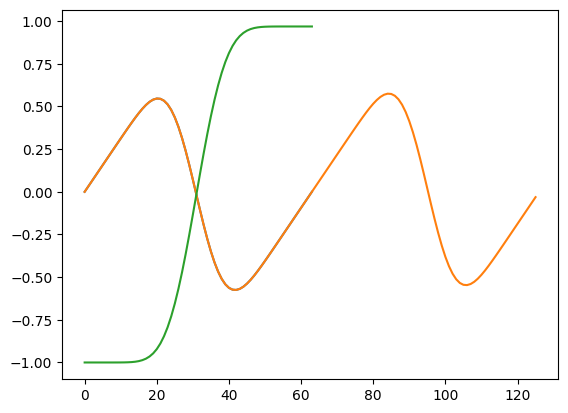

In [115]:

shift, C        = getShiftFunction(y1, 9, x)

homogeneous     = y1 - shift

plt.plot(homogeneous)
fext            = antisymmetricExtension(homogeneous)
plt.plot(fext)
homogeneous_i   = reconstruct(C, x, 0)
plt.plot(homogeneous_i)

/home/xerox/.local/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


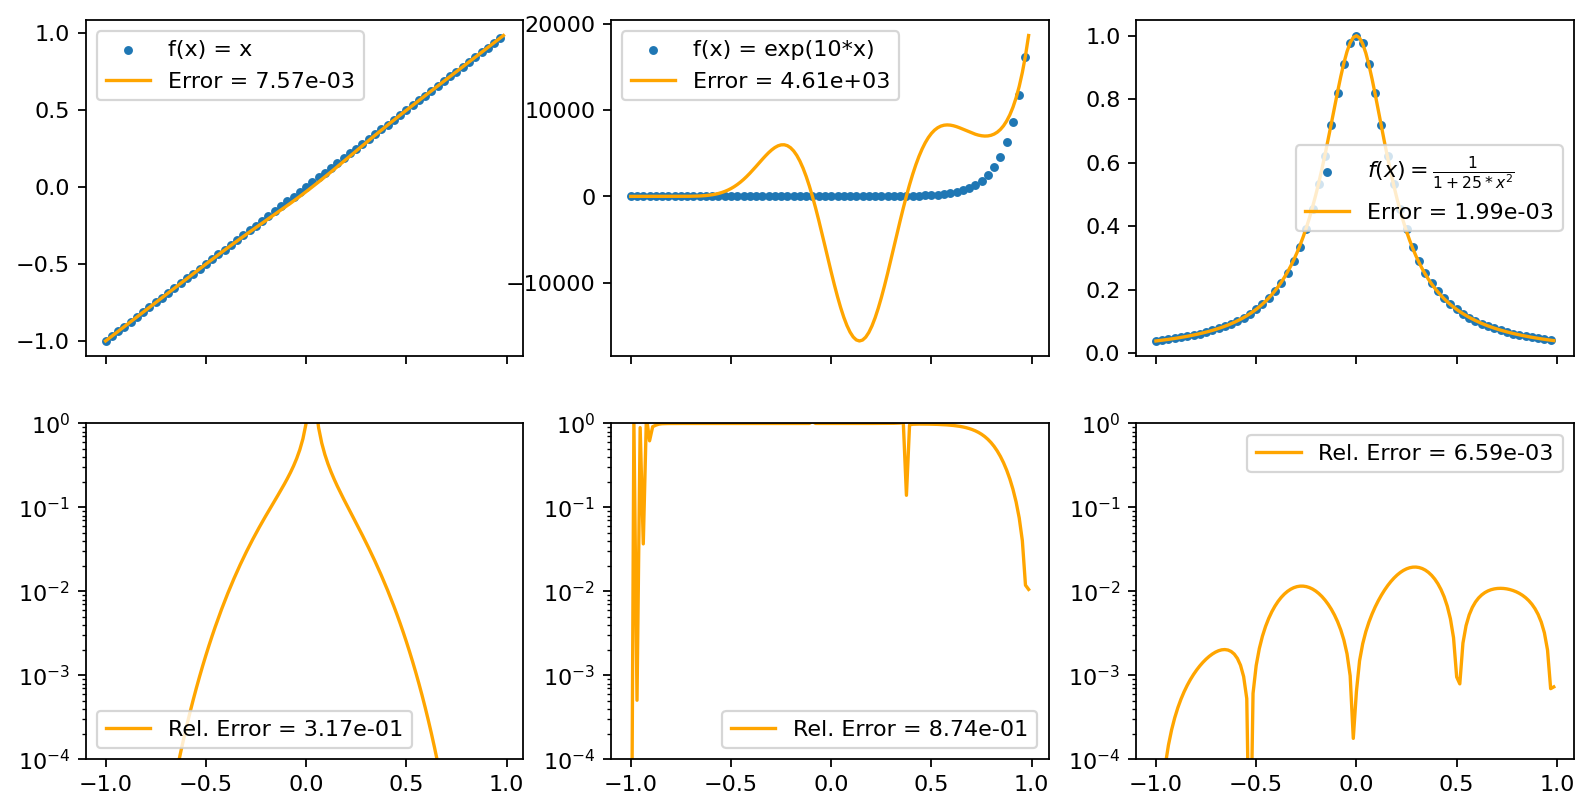

In [127]:
def int_4(y, order = 9):
    shift, coefficients  = getShiftFunction(y, order=order, x=x)
    homogeneous          = y - shift
    periodic             = antisymmetricExtension(homogeneous)
    inhomogeneous_i      = int_1(periodic, N = 2 * N - 2, Ni = 2 * Ni - int(Ni/N) * 2)[:Ni]
    homogeneous_i        = reconstruct(coefficients, xi, 0)
    return homogeneous_i + inhomogeneous_i


y1i = int_4(y1)
#y2i = int_4(y2)
#y3i = int_4(y3)
#
#
#plot_result(x, y1, y2, y3, xi, y1i, y2i, y3i)

In [ ]:
x = np.linspace(0, 2, 128)
fs = [np.exp(x), np.exp(5*x), np.sin(x), np.sin(x*10)]
ns = ["exp(x)", "exp(5x)", "sin(x)", "sin(10x)"]

for f, n in zip(fs, ns):
    plt.title(f"Fourier coefficients for {n}")
    plt.yscale("log")
    for order in [1, 3, 5, 7, 9, 11, 13]:
        shift, C = getShiftFunction(f, order, x)
        hom = f - shift
        ext = antisymmetricExtension(hom)
        fhat = scipy.fft.fft(ext)
        plt.plot(np.abs(fhat), label=f"order = {order}")
    plt.legend()
    plt.show()


for f, n in zip(fs, ns):
    plt.title(f"Fourier coefficients for {n}")
    for order in [1, 3, 5, 7, 9, 11, 13]:
        shift, C = getShiftFunction(f, order, x)
        hom = f - shift
        ext = antisymmetricExtension(hom)
        fhat = scipy.fft.fft(ext)
        y    = np.abs(fhat)[6:int(len(fhat)/2)]
        r    = np.arange(1, len(y)+1)
        #print(len(y), len(r))
        def fitfunc(x, beta):
            return np.log(y[0]) + beta * np.log(x)
        coeff, cov = scipy.optimize.curve_fit(fitfunc, r, np.log(y))
        #print(coeff)
        plt.loglog(r, y, label=f"order = {order} fit_order = {np.abs(coeff[0])}")
        #plt.loglog(r, np.exp(fitfunc(r, coeff[0])), label=f"fit with {y[0]} * x ** {coeff[0]}")
    plt.legend()
    plt.show()

## Gegenbauer reconstruction

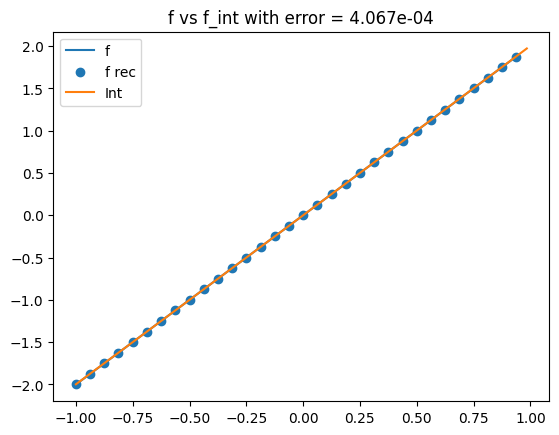

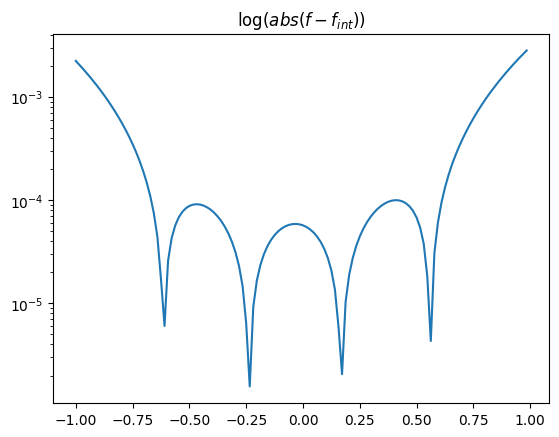

In [135]:

alpha = 1/4
beta = 1/4


def fft(f):
    n = len(f)
    N = int(n/2)
    fhat = np.zeros( n, dtype=complex)
    for k in range( n ):
        #x-array in [-1, 1]
        x     = (-1 + np.arange(n) / N )
        waves = np.exp(- 1j * np.pi * k * x )
        #normalisation
        C     = 1/(2 * N) 
        fhat[k] = C * np.sum( f *  waves )

    return fhat


def ifft(fhat):
    n = len(fhat)
    N = int(n/2)
    f = np.zeros( n, dtype=complex )
    for i, x in enumerate(-1 + np.arange(n) / N ):
        k     = np.arange( n )
        waves = np.exp(1j * np.pi * k * x )
        f[i]  = np.sum( fhat *  waves )

    return f

def fft2gegenbauer(fhat, alpha, beta):
    # 1 (zero-mode) + 2N - 1 (N positive frequencies, N-1 negative frequencies)
    # since we cannot distinguish the Nth positive and Nth negative frequency we need to discard them
    n   = len(fhat)
    # number of positive frequencies
    N   = int(n/2)

    # Gegenbauer parameter lambda as function of N
    lam = int(alpha * N)
    # Number of terms in Gegenbauer expansion
    m   = int(beta  * N)

    # Gamma function 
    gam = scipy.special.gamma(lam)
    # Gegenbauer coefficients
    g   = np.zeros(m + 1, dtype=complex)
    for l in range( m + 1 ):  
        # 2N - 1 (N positive frequencies, N-1 negative frequencies) 
        k      = np.concatenate([np.arange(1, N + 1),-np.flip(np.arange(1, N + 1))])
        fmat   = np.concatenate([fhat[1:N], [0.5 * fhat[N], 0.5 * fhat[N]], fhat[N+1:]])
        bessel = scipy.special.jv(l + lam, np.pi * k)
        coeff  = gam * bessel * (2 / (np.pi * k))**lam 
        g[l]   = (l == 0) * fhat[0] \
                 + (1j)**l * (l + lam) * np.sum(coeff * fmat)

    return g, lam


def igegenbauer(g, lam, x): 
    n = len(x)
    f = np.zeros(x.shape, dtype=complex)
    for l, coeff in enumerate(g):
        f += coeff * scipy.special.eval_gegenbauer(l, lam, x)

    return f

L  = 2
N  = 32
Ni = 128
def func(x): 
    return 2*x

alpha = beta  = 1/4
x  = np.linspace(-1, 1, N  + 1)[:-1]
xi = np.linspace(-1, 1, Ni + 1)[:-1]
f      = func(x) 

fhat   = fft(f)
frec   = ifft(fhat)
g, lam = fft2gegenbauer(fhat, alpha, beta) 
fint   = igegenbauer(g, lam, xi)

plt.title(f"f vs f_int with error = {np.mean(np.abs(func(xi) - fint)):3.3e}") 
plt.plot(x, f, label="f")
plt.scatter(x, frec.real, label="f rec")
plt.plot(xi, fint.real, label="Int")
plt.legend()
plt.show()
plt.title(r"$\log(abs(f - f_{int}))$") 
plt.yscale("log")
plt.plot(xi, np.abs(func(xi) - fint.real))
plt.show()

### Inverse polynomial reconstruction

In [128]:
import spectral_derivative as sd 
import numpy as np 
import scipy 
import matplotlib.pyplot as plt 


def getk(x): 
    N = int(len(x)/2)
    dx = x[1] - x[0]
    a  = x[0]
    b  = x[-1] + dx 
    return np.pi * np.concatenate([np.arange(0, N + 1),-np.flip(np.arange(1, N))]) / ((b - a)/2)


#Construct matrices T and V recursively for arbitrary lambda
def directW(x, N, lam): 
    # Even 
    W = np.zeros((2*N, 2*N), dtype=complex)
    
    for l in range(2*N):
        W[:, l] = scipy.fft.fft(C(x, lam, l))

    return W 

def C(x, lam, N, derivative_order = 0): 
    return scipy.special.chebyu(N).deriv(derivative_order)(x)
def reconstruct(g, lam, x, derivative_order = 0): 
    n = len(x)
    f = np.zeros(x.shape, dtype=complex)
    for l, coeff in enumerate(g):
        f += coeff * C(x, lam, l, derivative_order)

    return f

N = 10
x = np.linspace(-1, 1, 2*N)#[:-1]
alpha = 1
def func(x):
    return np.exp(-(x)**2/alpha) + np.exp(x) * 1j 

def ddfunc(x):
    #return 2 * x * np.exp(x**2)
    #return (2 + 4 * x**2) * np.exp(x**2)
    return (-2/alpha + 4 * (x)**2/alpha**2) * np.exp(-(x)**2/alpha)

f = func(x) 
lam = 0.5

fhat = scipy.fft.fft(f) 
inv = scipy.linalg.inv(directW(x, N, lam))

g = np.matmul(inv, fhat) 
x = np.linspace(-1, 1, 100)
frec = reconstruct(g, lam, x) 

plt.title(f"Reconstructed f with error {np.mean(np.abs(func(x) - frec))}") 
plt.plot(x, np.abs(func(x)), label="Original")
plt.plot(x, np.abs(frec), label="Reconstructed")
plt.legend()
plt.show() 

ModuleNotFoundError: No module named 'spectral_derivative'

class IPRReconstruction:
    def __init__(self, x, lam = 1, cutoff = 100): 
        self.cutoff                 = cutoff 
        self.lam                    = lam 
        W                           = self.directW(self.shiftx(x), int(len(x)/2), lam)
        self.p, self.l, self.u      = scipy.linalg.lu(W, permute_l=False)
        
    def poly(self, N): 
        return scipy.special.chebyt(N)
    
    def reconstruct(self, g): 
        f = np.poly1d([])
        for l, coeff in enumerate(g):
            f += coeff * self.poly(l)

        return f

    def __call__(self, x, order = 0):
        return self.rec.deriv(order)((x - self.s)*self.c) * self.c**order


    #Construct matrices T and V recursively for arbitrary lambda
    def directW(self, x, N, lam): 
        # Even 
        W = np.zeros((2*N, 2*N), dtype=complex)
        
        for l in range(2*N):
            W[:, l] = scipy.fft.fft(self.poly(l)(x))

        return W 

    
    def shiftx(self, x):
        dx = x[1] - x[0]
        self.a = x[0]
        self.b = x[-1]
        self.s = (self.a + self.b)/2
        self.c = 1 / ((self.b - self.a)/2)
        sx = (x - self.s) * self.c
        return  sx
        
    def gaussWithTruncation(self, A, B):
        """
        Solve Ax = B using Gaussian elimination and LU decomposition with truncation for stability of IPR
        """
        # LU decomposition with pivot
        p, l, u = scipy.linalg.lu(A, permute_l=False)
        return self.solveLUWithTruncation(B, p, l, u)
        
    
    def compute(self, psi, p = None, l = None, u = None):
        B = scipy.fft.fft(psi)

        if p is None:
            p = self.p 
        if l is None: 
            l = self.l
        if u is None: 
            u = self.u
            
        # forward substitution to solve for Ly = B
        y = np.zeros(B.size, dtype=complex)
        for m, b in enumerate((p.T @ B).flatten()):
            y[m] = b
            # skip for loop if m == 0
            if m:
                for n in range(m):
                    y[m] -= y[n] * l[m,n]
            y[m] /= l[m, m]

        # truncation for IPR
        c = np.abs(y) < self.cutoff * np.finfo(float).eps
        y[c] = 0

        # backward substitution to solve for y = Ux
        x = np.zeros(B.size, dtype=complex)
        lastidx = B.size - 1  # last index
        for midx in range(B.size):
            m = B.size - 1 - midx  # backwards index
            x[m] = y[m]
            if midx:
                for nidx in range(midx):
                    n = B.size - 1  - nidx
                    x[m] -= x[n] * u[m,n]
            x[m] /= u[m, m]
        self.rec = self.reconstruct(x)
        

x = np.linspace(0, 1, 32)
order = 9

def func(x, derivative_order=0): 
    return np.exp(x)
    #return np.real((1j*10)**derivative_order*np.exp(1j*10*x))

f = func(x)

ipr = IPRReconstruction(x, 1, 1e7)

plt.plot(f, label="f")
ipr.compute(f)
plt.plot(ipr(x, 8))
plt.legend()
plt.show()
#xeval = shiftx(x)
dx = x[1] - x[0]
Nrec = 32
lam = 1
lipr = IPRReconstruction(x[:Nrec], lam, 1e7)
lipr.compute(f[:Nrec])
ripr = IPRReconstruction(x[-Nrec:], lam, 1e7)
ripr.compute(f[-Nrec:])
Dl = []
Dr = []
for i in range(1, order + 1):
    Dl.append(lipr(x[0], i))
    Dr.append(ripr(x[-1], i))
    
print("Relative mismatch at boundaries")
for i in range(order): 
    print(f"L: {np.abs(func(x[0], i+1) - Dl[i])/(np.abs(Dl[i])+1e-8):3.8f} R: {np.abs(func(x[-1], i+1) - Dr[i])/(np.abs(Dr[i])+1e-8):3.8f}")

# Fourier continuations of third kind

This notebook implements Fourier continuations of the third kind with iterative refinement and overcollocation as explained in 

"A Comparison of Numerical Algorithms for Fourier Extension of the First, Second, and Third Kinds"

John P. Boyd

Department of Atmospheric, Oceanic and Space Science, University of Michigan, 2455 Hayward Avenue,
Ann Arbor, Michigan 48109-2143

Received July 6, 2001; revised February 12, 2002"

In [140]:
import numpy as np 
import matplotlib.pyplot as plt 
import scipy 

In [141]:
def getFPICSUMatrix(N, Ncoll, theta, chi): 
    x = np.zeros(Ncoll)
    M = np.zeros((Ncoll, N))
    for i in range(Ncoll):
        for j in range(N):
            #Collocation points uniformly distributed over the positive half
            #of the physical interval x in [0, chi]
            x[i]    = i * chi / (Ncoll - 1) 
            M[i, j] = np.cos(j * np.pi / theta * x[i])
    return M, x

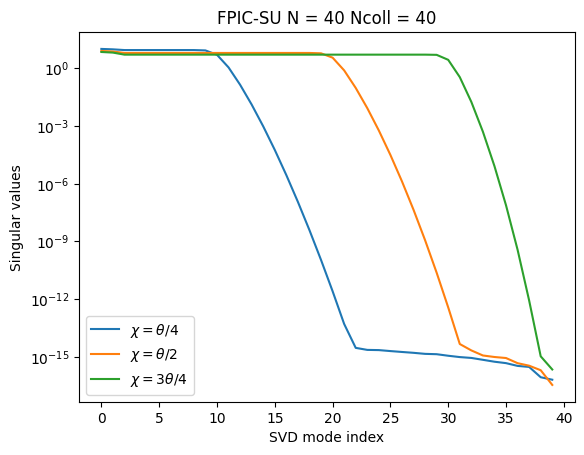

In [142]:

N     = 40
Ncoll = N

#The extended domain is split up into the physical and extension parts
#  [-theta, -chi, chi, theta]
theta = np.pi    # extension domain boundary
plt.title(f"FPIC-SU N = {N} Ncoll = {Ncoll}")
plt.ylabel("Singular values")
plt.xlabel("SVD mode index") 
plt.yscale("log") 

chis   = [theta/4, theta/2, 3*theta/4]  # physical domain boundary
labels = [r"$\chi = \theta/4$", r"$\chi = \theta/2$", r"$\chi = 3\theta/4$"]

for chi, label in zip(chis, labels): 
    M, x = getFPICSUMatrix(N, Ncoll, theta, chi) 
    y = scipy.linalg.svdvals(M, overwrite_a=False, check_finite=True)
    x = np.arange(len(y))
    plt.plot(x, y, label=label)
plt.legend()
plt.show()

Compute pseudoinverse of matrix using SVD:

For any matrix $M \in \mathbb{R}^{m\times n}$ , there exist orthogonal matrices $M \in \mathbb{R}^{m\times m}$ and $V \in \mathbb{R}^{n\times n}$ and scalars $σ_1 , . . . , σ_n$ such that
$$ M = U S V^T$$

In [143]:
chi = theta/2 

M, x = getFPICSUMatrix(N, Ncoll, theta, chi) 
#Factorizes the matrix a into two unitary matrices U and Vh, and a 1-D array s of singular values (real, non-negative) such that a == U @ S @ Vh, where S is a suitably shaped matrix of zeros with main diagonal s.
U, s, Vh = scipy.linalg.svd(M)

In [144]:
def invertM(M, cutoff):
    U, s, Vh = scipy.linalg.svd(M)
    sinv = np.zeros(M.T.shape)
    for i in range(np.min(M.shape)):
        if s[i] < cutoff:
            sinv[i, i] = 0
        else:
            sinv[i, i] = 1/s[i]
    return Vh.T @ sinv @ U.T

#Test implementation of invert M
A = np.random.rand(10, 10)
np.testing.assert_allclose(np.abs(scipy.linalg.inv(A) - invertM(A, 0)), 0, atol=1e-10)


Finally compute the periodic extension of an even function ($f(x) = x^2$ in this example)

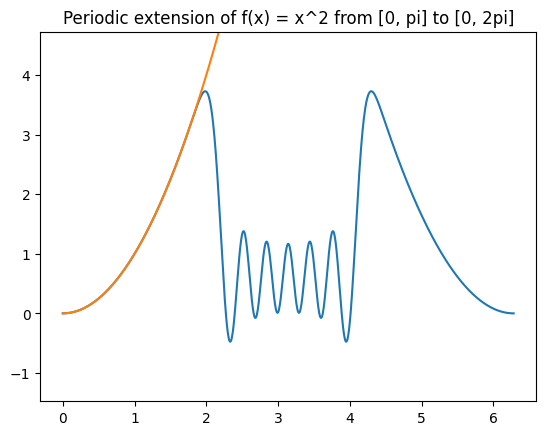

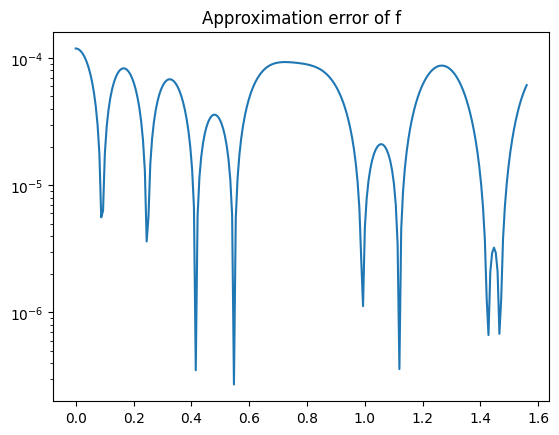

In [145]:
N     = 32
Ncoll = N
theta = np.pi
chi   = theta/2 
M, x  = getFPICSUMatrix(N, Ncoll, theta, chi) 

def func(x):
    return x**2

f     = func(x) 
Minv  = invertM(M, 1e-14)
a     = Minv @ f

def reconstruct(x, a, theta): 
    rec = np.zeros(x.shape) 
    for j, coeff in enumerate(a): 
        rec += coeff * np.cos(np.pi / theta * j * x)
    return rec

xext = np.linspace(0, 2*theta, 1000)
frec = reconstruct(xext, a, theta) 

plt.title("Periodic extension of f(x) = x^2 from [0, pi] to [0, 2pi]")
plt.plot(xext, frec, label="Extension") 
plt.plot(xext, func(xext), label="Original") 
plt.ylim(np.min(frec) - 1, np.max(frec) + 1)
plt.show() 
plt.title("Approximation error of f")
ul = np.argwhere(xext<chi)[-1][0]
xorg = xext[:ul]
plt.yscale("log")
plt.plot(xorg, np.abs(func(xorg) - frec[:ul]))
plt.show() 

Improve this result by using iterative refinement

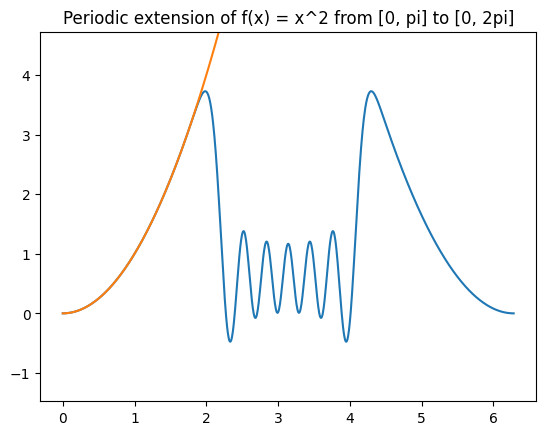

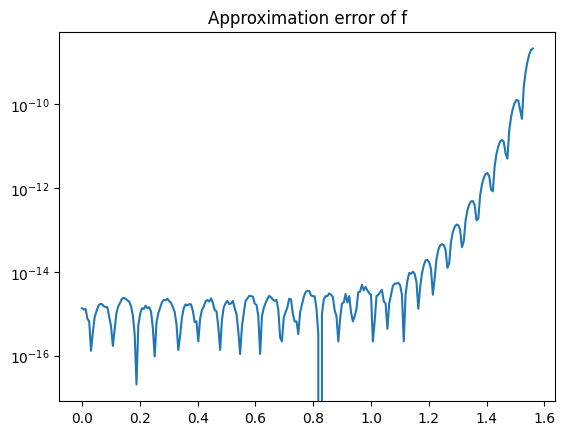

In [146]:
def iterativeRefinement(M, Minv, f, threshold = 100, maxiter = 5): 
    a       = Minv @ f
    r       = M @ a - f
    counter = 0
    while np.linalg.norm(r) > 100 * np.finfo(float).eps * np.linalg.norm(a) and counter < maxiter: 
        delta    = Minv @ r
        a        = a - delta 
        r        = M @ a - f
        counter += 1
    return a

N     = 32
Ncoll = N
theta = np.pi
chi   = theta/2 
M, x  = getFPICSUMatrix(N, Ncoll, theta, chi) 

def func(x):
    return x**2

f     = func(x) 
Minv  = invertM(M, 1e-14)
a     = iterativeRefinement(M, Minv, f, threshold = 100, maxiter = 3)

xext = np.linspace(0, 2*theta, 1000)
frec = reconstruct(xext, a, theta) 

plt.title("Periodic extension of f(x) = x^2 from [0, pi] to [0, 2pi]")
plt.plot(xext, frec, label="Extension") 
plt.plot(xext, func(xext), label="Original") 
plt.ylim(np.min(frec) - 1, np.max(frec) + 1)
plt.show() 
plt.title("Approximation error of f")
ul = np.argwhere(xext<chi)[-1][0]
xorg = xext[:ul]
plt.yscale("log")
plt.plot(xorg, np.abs(func(xorg) - frec[:ul]))
plt.show() 

In [147]:
Reproduce figure 11

SyntaxError: invalid syntax (1742347373.py, line 1)

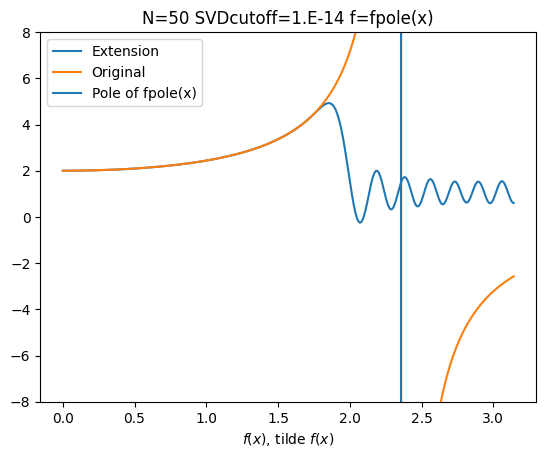

In [148]:

N     = 50
Ncoll = N
theta = np.pi
chi   = theta/2 
M, x  = getFPICSUMatrix(N, Ncoll, theta, chi) 

def func(x):
    p34 = 0.75 * np.pi
    return p34 / (p34 - x) + p34 / (p34 + x) 

f     = func(x) 
Minv  = invertM(M, 1e-14)
a     = iterativeRefinement(M, Minv, f, threshold = 100, maxiter = 3)

xext = np.linspace(0, theta, 1000)
frec = reconstruct(xext, a, theta) 

plt.title("N=50 SVDcutoff=1.E-14 f=fpole(x)")
plt.plot(xext, frec, label="Extension") 
plt.plot(xext, func(xext), label="Original") 
plt.axvline(x = 2.356, label="Pole of fpole(x)")
plt.ylim(-8, 8)
plt.xlabel(r"$x$")
plt.xlabel(r"$f(x)$, tilde $f(x)$")
plt.legend()
plt.show()

Reproduce figure 13

[0.         0.03205707 0.06411414 0.0961712  0.12822827 0.16028534
 0.19234241 0.22439948 0.25645654 0.28851361 0.32057068 0.35262775
 0.38468481 0.41674188 0.44879895 0.48085602 0.51291309 0.54497015
 0.57702722 0.60908429 0.64114136 0.67319843 0.70525549 0.73731256
 0.76936963 0.8014267  0.83348377 0.86554083 0.8975979  0.92965497
 0.96171204 0.9937691  1.02582617 1.05788324 1.08994031 1.12199738
 1.15405444 1.18611151 1.21816858 1.25022565 1.28228272 1.31433978
 1.34639685 1.37845392 1.41051099 1.44256806 1.47462512 1.50668219
 1.53873926 1.57079633]


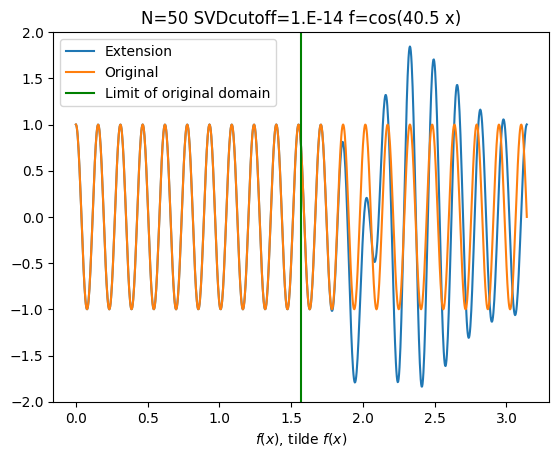

In [149]:

N     = 50
Ncoll = N
theta = np.pi
chi   = theta/2 
M, x  = getFPICSUMatrix(N, Ncoll, theta, chi) 
print(x)
def func(x):
    return np.cos(40.5*x) 

f     = func(x) 
Minv  = invertM(M, 1e-14)
a     = iterativeRefinement(M, Minv, f, threshold = 100, maxiter = 3)

xext = np.linspace(0, theta, 1000)
frec = reconstruct(xext, a, theta) 

plt.title("N=50 SVDcutoff=1.E-14 f=cos(40.5 x)")
plt.plot(xext, frec, label="Extension") 
plt.plot(xext, func(xext), label="Original") 
plt.axvline(x = np.pi/2, label="Limit of original domain", c="green")
plt.ylim(-2, 2)
plt.xlabel(r"$x$")
plt.xlabel(r"$f(x)$, tilde $f(x)$")
plt.legend()
plt.show()

## Why overcollocation is good

Reproduce figure 15

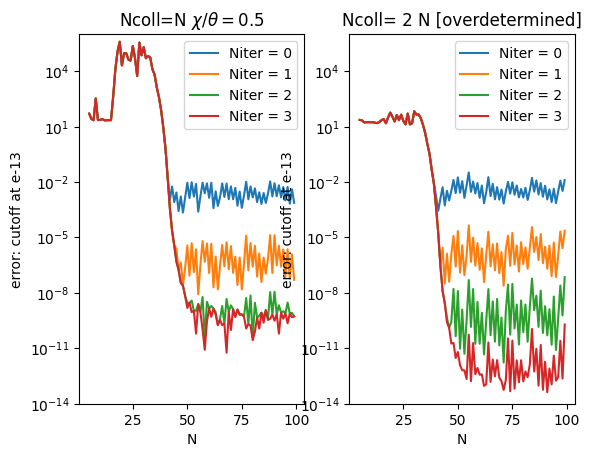

In [150]:

theta = np.pi
chi   = theta/2 
xext  = np.linspace(0, theta, 1000)
ul    = np.argwhere(xext<chi)[-1][0]

def func(x):
    return np.cos(40.5*x) 

fig, ax = plt.subplots(1, 2) 

ax[0].set_title(r"Ncoll=N $\chi/\theta=0.5$")
ax[0].set_xlabel("N")
ax[0].set_ylabel("error: cutoff at e-13")
ax[0].set_yscale("log")
ax[0].set_ylim([1e-14, 1e6])
ax[1].set_title("Ncoll= 2 N [overdetermined]")
ax[1].set_xlabel("N")
ax[1].set_ylabel("error: cutoff at e-13")
ax[1].set_yscale("log")
ax[1].set_ylim([1e-14, 1e6])

Ns         = np.arange(5, 100, 1) 
iterations = [0, 1, 2, 3]
cutoff     = 1e-13 
threshold  = 10 
for iteration in iterations:
    err = []
    for N in Ns: 
        Ncoll = N
        M, x  = getFPICSUMatrix(N, Ncoll, theta, chi) 
        f     = func(x) 
        Minv  = invertM(M, cutoff)
        a    = iterativeRefinement(M, Minv, f, threshold = threshold, maxiter = iteration)
        frec = reconstruct(xext, a, theta) 
        err.append(np.linalg.norm((frec - func(xext))[:ul]))

    ax[0].plot(Ns, err, label=f"Niter = {iteration}") 

ax[0].legend()

for iteration in iterations:
    err = []
    for N in Ns: 
        Ncoll = N * 2
        M, x  = getFPICSUMatrix(N, Ncoll, theta, chi) 
        f     = func(x) 
        Minv  = invertM(M, cutoff)
        a    = iterativeRefinement(M, Minv, f, threshold = threshold, maxiter = iteration)
        frec = reconstruct(xext, a, theta) 
        err.append(np.linalg.norm((frec - func(xext))[:ul]))

    ax[1].plot(Ns, err, label=f"Niter = {iteration}") 

ax[1].legend()

plt.show()